### <center>San Jose State University<br>Department of Applied Data Science<br><br>**DATA 201<br>Database Technologies for Data Analytics**<br><br>Spring 2025<br>Instructor: Ron Mak</center>

# Database Design Example: Car Dealership

#### This example will demonstrate
- How to design a database that meets a set of requirements.
- How to formulate queries in a step-by-step manner.

#### **Requirements**: A database for the sales manager of **Golden Lemon Used Car Dealership** to keep track of which salesperson sold which vehicles to which customers during each month:
- Each salesperson has a name.
- Each customer has a name and gender.
- Each car has a car identification number (VIN), company, model, year, and price.
- Each transaction includes the month when it occurred.
- A salesperson creates transactions to sell cars.
- A transaction can include many cars, including none.
- Each sold car is included in a single transaction.
- A transaction belongs to only one customer.
- A customer have many transactions, but at least one.
- A customer can have transactions with different salespeople. 

## Conceptual: ER diagram

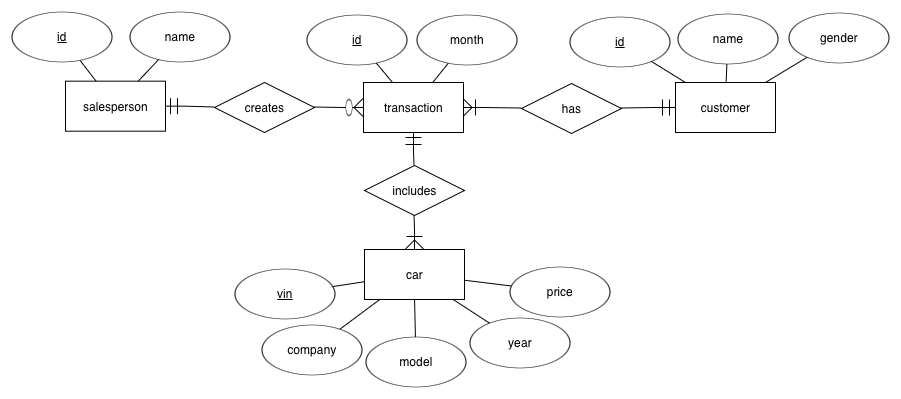

## Logical: Relational schema

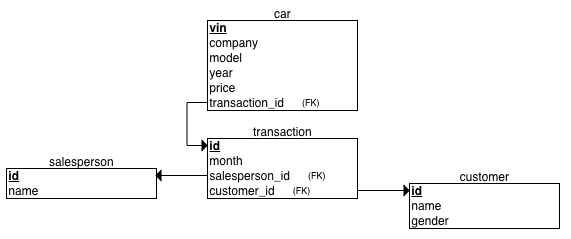

In [1]:
from data201 import db_connection, df_query

In [2]:
conn = db_connection(config_file = 'CarDealership.ini')
cursor = conn.cursor()

## Queries

### **1.** In the month of September, which salesperson sold the **most** cars and how many?
#### Why is the following query incorrect?

In [3]:
df_query(conn,
    """
    SELECT sp.name AS "Top Sept sales person", 
           count(sp.name) AS "Cars sold" 
    FROM salesperson sp
    JOIN transaction t
      ON t.salesperson_id = sp.id
     AND t.month = 9
    GROUP BY sp.name
    ORDER BY count(sp.name) DESC
    LIMIT 1
    """
)

Top Sept sales person  Cars sold
0                Leslie          4

#### Before we can tell who has sold the most cars, we must know **how many cars** each salesperson sold in September.

In [4]:
df_query(conn, 
    """
    SELECT sp.name AS "Sales person",
           COUNT(sp.name) AS "Cars sold in Sept"
    FROM salesperson sp
    JOIN transaction t
      ON t.salesperson_id = sp.id
    JOIN car
      ON car.transaction_id = t.id
    WHERE t.month = 9
    GROUP BY sp.name
    ORDER BY sp.name
    """
)

Sales person  Cars sold in Sept
0         Jing                  2
1       Leslie                  4
2       Shaila                  4
3        Steve                  1
4        Vijay                  1

#### OK. More than one salesperson can tie selling the most cars. 
#### Let's make the above query a view.

In [5]:
cursor.execute('DROP VIEW IF EXISTS sept_sales')

cursor.execute( 
    """
    CREATE VIEW sept_sales AS
    SELECT sp.name AS sales_person,
           COUNT(sp.name) AS sept_count
    FROM salesperson sp
    JOIN transaction t
      ON t.salesperson_id = sp.id
    JOIN car
      ON car.transaction_id = t.id
    WHERE t.month = 9
    GROUP BY sp.name
    ORDER BY sp.name
    """
)

df_query(conn, 'SELECT * FROM sept_sales')

sales_person  sept_count
0         Jing           2
1       Leslie           4
2       Shaila           4
3        Steve           1
4        Vijay           1

#### The maximum number of vehicles sold in September.

In [6]:
df_query(conn, 
    """ 
    SELECT MAX(sept_count) 
    FROM sept_sales
    """
)

MAX(sept_count)
0                4

#### Who sold the most vehicles in September and how many?

In [7]:
df_query(conn, 
    """ 
    SELECT sales_person AS "Top Sept sales persons",
           sept_count AS "Sept cars sold"
    FROM sept_sales
    WHERE sept_count = (
            SELECT MAX(sept_count)
            FROM sept_sales)
    ORDER BY sales_person
    """
)

Top Sept sales persons  Sept cars sold
0                 Leslie               4
1                 Shaila               4

### **2.** Which salespersons in September sold **fewer than the average** number of cars in September? 

#### First, what is the average sales in September?

In [8]:
df_query(conn, 
    """ 
    SELECT AVG(sept_count) AS "Average Sept sales"
    FROM sept_sales
    """
)

Average Sept sales
0                 2.4

#### Here are September's poor performers.

In [9]:
df_query(conn, 
    """ 
    SELECT sales_person AS "Poor Sept performers" 
    FROM sept_sales
    WHERE sept_count < (
            SELECT AVG(sept_count)
            FROM sept_sales)
    ORDER BY sales_person
    """
)

Poor Sept performers
0                 Jing
1                Steve
2                Vijay

### **3.** In September, what is the **number and average price** of cars sold in each group consisting of **a salesperson**, a **car company**, and a **customer gender**? Only consider salespersons who **sold two or more cars** in the group.

#### First, let's see who sold what of each car company and model to each customer gender.

In [10]:
df_query(conn, 
    """ 
    SELECT sp.name AS "Sales person", 
           t.id AS "Transaction ID",
           car.company AS "Car company", 
           car.model AS "Car model", 
           cust.gender AS "Customer gender", 
           CONCAT('$', FORMAT(car.price, 2)) AS "Car price"
    FROM salesperson sp
    JOIN transaction t
      ON t.salesperson_id = sp.id
    JOIN car
      ON car.transaction_id = t.id
    JOIN customer cust
      ON cust.id = t.customer_id
    WHERE t.month = 9
    ORDER BY sp.name, car.company, car.model, cust.gender
    """
)

Sales person Transaction ID Car company Car model Customer gender  \
0          Jing          T0007        Ford    Fiesta               m   
1          Jing          T0007        Ford     Focus               m   
2        Leslie          T0001       Honda    Accord               f   
3        Leslie          T0011       Volvo    240 DL               f   
4        Leslie          T0001       Volvo       850               f   
5        Leslie          T0004       Volvo       X90               f   
6        Shaila          T0002       Chevy      Nova               m   
7        Shaila          T0010       Honda     Civic               m   
8        Shaila          T0002      Toyota     Prius               m   
9        Shaila          T0010  Volkswagen    Beetle               m   
10        Steve          T0005        Ford    Taurus               m   
11        Vijay          T0006       Volvo       S60               m   

     Car price  
0   $10,000.00  
1      $700.00  
2    $2,200.00  
3    $1,000.00  
4    $5,000.00  
5   $11,000.00  
6    $1,000.00  
7    $5,000.00  
8   $15,000.00  
9      $200.00  
10  $10,000.00  
11  $16,000.00

#### Now group the results by salesperson, car company, and customer gender, and compute the average car price in each group.

In [11]:
df_query(conn,
    """ 
    SELECT sp.name AS "Sales person", 
           car.company AS "Car company", 
           cust.gender AS "Customer gender", 
           COUNT(car.company) AS "Cars sold", 
           CONCAT('$', FORMAT(AVG(car.price), 2)) AS "Avg car price"
    FROM salesperson sp
    JOIN transaction t
      ON t.salesperson_id = sp.id
    JOIN car
      ON car.transaction_id = t.id
    JOIN customer cust
      ON cust.id = t.customer_id
    WHERE t.month = 9
    GROUP BY sp.name, car.company, cust.gender
    ORDER BY sp.name, car.company, cust.gender
    """
)

Sales person Car company Customer gender  Cars sold Avg car price
0         Jing        Ford               m          2     $5,350.00
1       Leslie       Honda               f          1     $2,200.00
2       Leslie       Volvo               f          3     $5,666.67
3       Shaila       Chevy               m          1     $1,000.00
4       Shaila       Honda               m          1     $5,000.00
5       Shaila      Toyota               m          1    $15,000.00
6       Shaila  Volkswagen               m          1       $200.00
7        Steve        Ford               m          1    $10,000.00
8        Vijay       Volvo               m          1    $16,000.00

#### We only want to see the groups where at least 2 cars were sold.

In [12]:
df_query(conn, 
    """ 
    SELECT sp.name AS "Sales person", 
           car.company AS "Car company", 
           cust.gender AS "Customer gender", 
           COUNT(car.company) AS "Cars sold >= 2", 
           CONCAT('$', FORMAT(AVG(car.price), 2)) AS "Avg car price"
    FROM salesperson sp
    JOIN transaction t
      ON t.salesperson_id = sp.id
    JOIN car
      ON car.transaction_id = t.id
    JOIN customer cust
      ON cust.id = t.customer_id
    WHERE t.month = 9
    GROUP BY sp.name, car.company, cust.gender
    HAVING COUNT(car.company) >= 2
    ORDER BY sp.name, car.company, cust.gender
    """
)

Sales person Car company Customer gender  Cars sold >= 2 Avg car price
0         Jing        Ford               m               2     $5,350.00
1       Leslie       Volvo               f               3     $5,666.67

In [13]:
cursor.close()
conn.close()